In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

Read STM Au(111) data into memory via ImageDataGenerator.

In [5]:
root_dir ='D:\\Research\\STM Tip Prep Data\\'
base_dir =  os.path.join(root_dir, 'herringbone_and_notherringbone')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_herringbone_dir = os.path.join(train_dir, 'herringbone')
train_notherringbone_dir = os.path.join(train_dir, 'notherringbone')
validation_herringbone_dir = os.path.join(validation_dir, 'herringbone')
validation_notherringbone_dir = os.path.join(validation_dir, 'notherringbone')

## Inspect the data

In [6]:
num_herringbone_tr = len(os.listdir(train_herringbone_dir))
num_notherringbon_tr = len(os.listdir(train_notherringbone_dir))

num_herringbon_val = len(os.listdir(validation_herringbone_dir))
num_notherringbon_val = len(os.listdir(validation_notherringbone_dir))

total_train = num_herringbone_tr + num_notherringbon_tr
total_val = num_herringbon_val + num_notherringbon_val

In [7]:
print('total training herringbone images:', num_herringbone_tr)
print('total training notherringbone images:', num_notherringbon_tr)

print('total validation herringbone images:', num_herringbon_val)
print('total validation notherringbone images:', num_notherringbon_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training herringbone images: 279
total training notherringbone images: 158
total validation herringbone images: 50
total validation notherringbone images: 50
--
Total training images: 437
Total validation images: 100


# Set Model Parameters

In [8]:
# Number of training examples to process before updating our models variables
BATCH_SIZE = 100 
# Our training data consists of images with width of 150 pixels and height of 150 pixels
IMG_SHAPE  = 150

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [9]:
# Generator for our training data
train_image_generator      = ImageDataGenerator(rescale=1./255)
# Generator for our validation data
validation_image_generator = ImageDataGenerator(rescale=1./255)  

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 437 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 100 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [12]:
sample_training_images, _ = next(train_data_gen) 

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

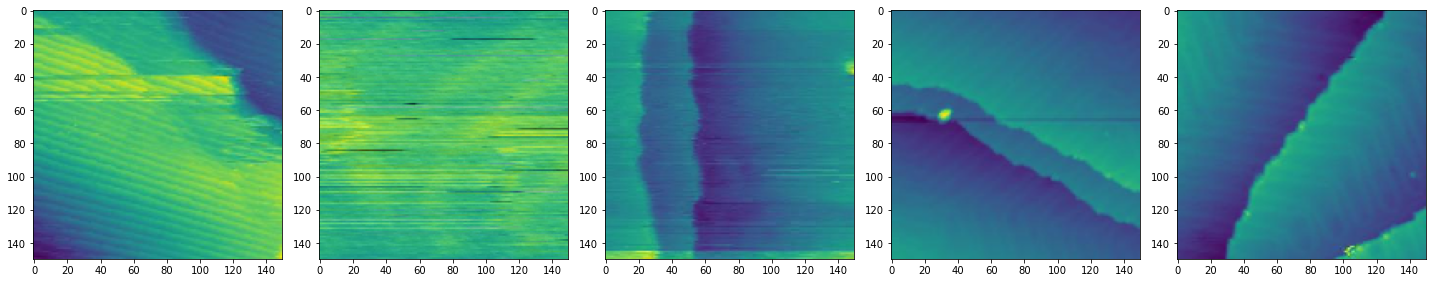

In [14]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — herringbone and not herringbone — using `softmax`. 

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [18]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Train for 5 steps, validate for 1 steps
Epoch 1/100
5/5 [==============================] - 3s 550ms/step - loss: 0.7484 - accuracy: 0.6751 - val_loss: 0.6945 - val_accuracy: 0.5400
Epoch 2/100
5/5 [==============================] - 1s 134ms/step - loss: 0.6390 - accuracy: 0.7002 - val_loss: 0.7743 - val_accuracy: 0.4900
Epoch 3/100
5/5 [==============================] - 1s 137ms/step - loss: 0.6110 - accuracy: 0.6979 - val_loss: 0.7698 - val_accuracy: 0.4900
Epoch 4/100
5/5 [==============================] - 1s 143ms/step - loss: 0.6113 - accuracy: 0.7002 - val_loss: 0.7617 - val_accuracy: 0.5100
Epoch 5/100
5/5 [==============================] - 1s 145ms/step - loss: 0.5941 - accuracy: 0.7048 - val_loss: 0.7995 - val_accuracy: 0.5200
Epoch 6/100
5/5 [==============================] - 1s 148ms/step - loss: 0.5861 - accuracy: 0.7048 - val_loss: 0.7975 - val_accuracy: 0.5100
Epoch 7/100
5/5 [==============================] - 1s 145ms/step - loss: 0.5843 - accuracy: 0.7002 - val_loss: 0.8

# Visualizing results of the training

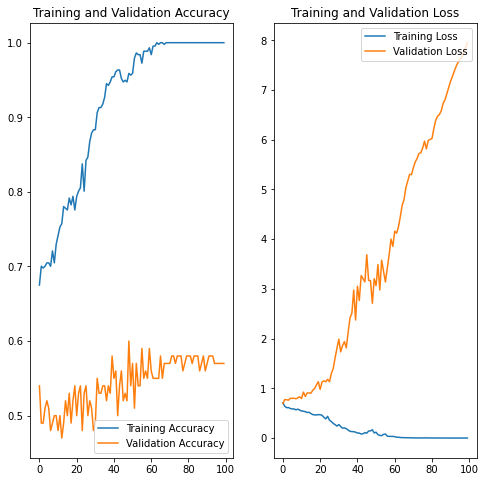

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.


In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Flip the image horizontally



We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing horizontal_flip=True as an argument to the ImageDataGenerator class.


In [21]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 437 images belonging to 2 classes.


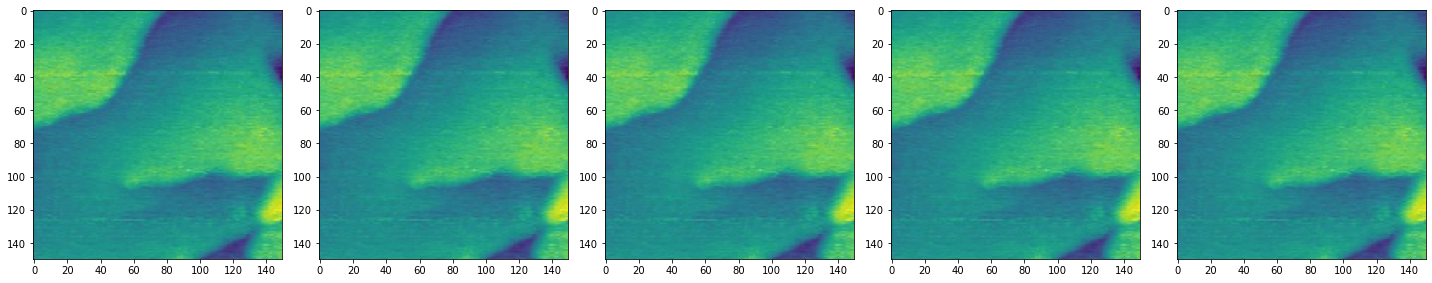

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Rotate the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [23]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 437 images belonging to 2 classes.


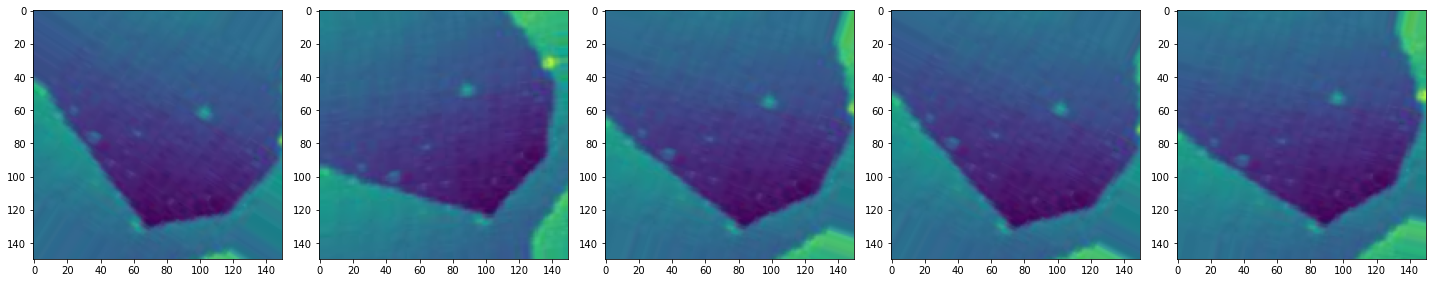

In [24]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Applying zoom to the image

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 437 images belonging to 2 classes.


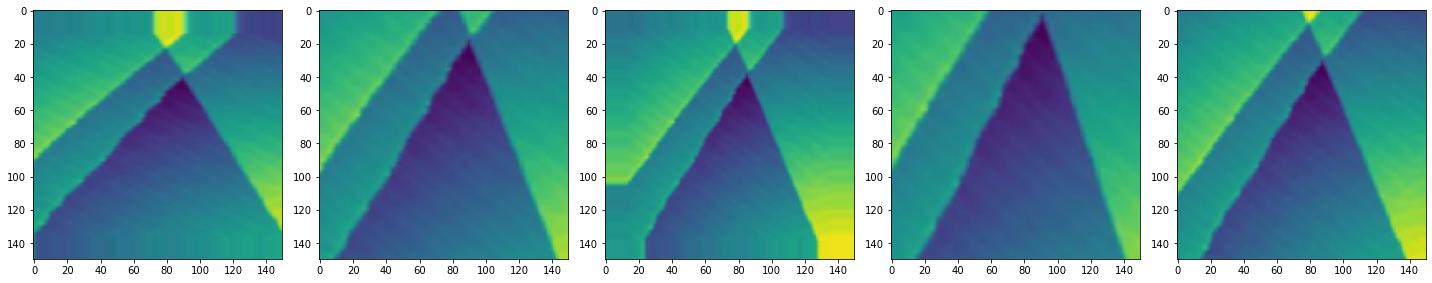

In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Combine all augmentations

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.


In [27]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 437 images belonging to 2 classes.


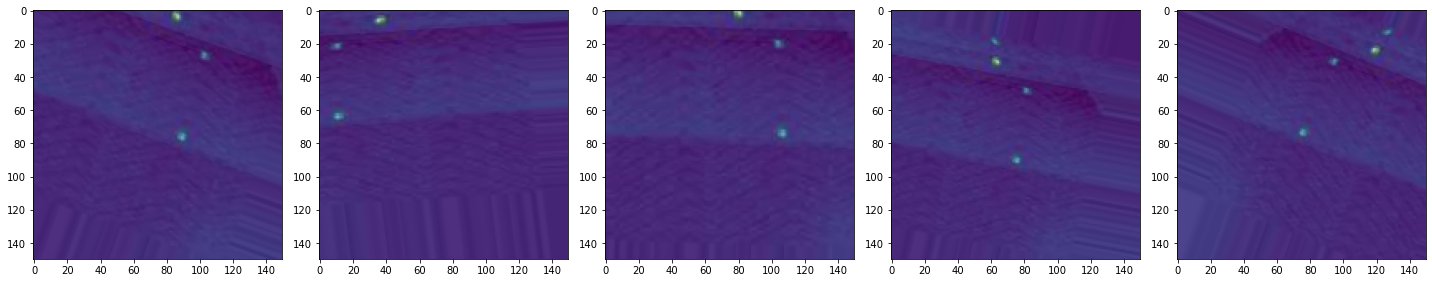

In [28]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [29]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 100 images belonging to 2 classes.


# Update Model 

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

## Train updated model

In [33]:
# Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Train for 5 steps, validate for 1 steps
Epoch 1/100
5/5 [==============================] - 3s 598ms/step - loss: 0.7080 - accuracy: 0.4668 - val_loss: 0.7378 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 2s 456ms/step - loss: 0.6290 - accuracy: 0.6407 - val_loss: 0.7508 - val_accuracy: 0.5200
Epoch 3/100
5/5 [==============================] - 2s 481ms/step - loss: 0.6132 - accuracy: 0.6957 - val_loss: 0.7193 - val_accuracy: 0.5400
Epoch 4/100
5/5 [==============================] - 2s 477ms/step - loss: 0.5939 - accuracy: 0.6842 - val_loss: 0.8332 - val_accuracy: 0.5200
Epoch 5/100
5/5 [==============================] - 2s 446ms/step - loss: 0.6046 - accuracy: 0.7002 - val_loss: 0.7777 - val_accuracy: 0.5100
Epoch 6/100
5/5 [==============================] - 2s 483ms/step - loss: 0.6030 - accuracy: 0.6934 - val_loss: 0.7536 - val_accuracy: 0.5100
Epoch 7/100
5/5 [==============================] - 2s 477ms/step - loss: 0.5938 - accuracy: 0.6979 - val_loss: 0.7

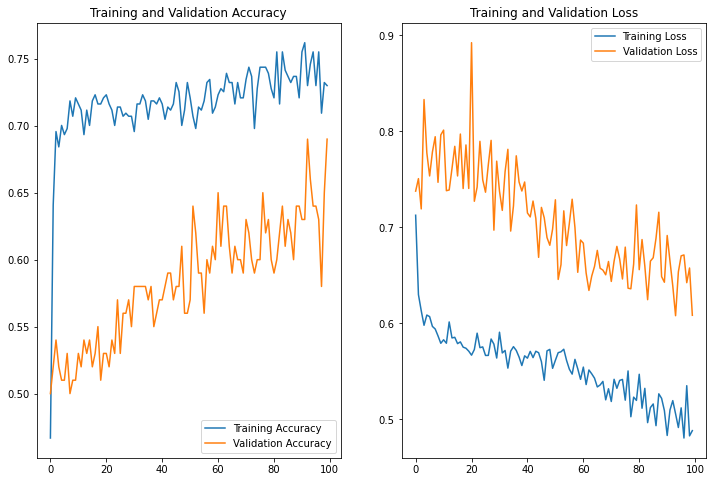

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()